<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#BERT" data-toc-modified-id="BERT-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>BERT</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» c BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# Загружаем необходимые библиотеки

import pandas as pd
import numpy as np

import re
import os
import sys
import csv

import nltk 
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
nltk.download('wordnet')
import string

from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 100)

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mordovets.i/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mordovets.i/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/Users/mordovets.i/opt/anaconda3/lib/python3.8/site-packages/lightgbm/__init__.py:42: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  warnings.warn("Starting from version 2.2.1, the library file in distribution wheels for macOS "


In [2]:
data_path = "/Users/mordovets.i/toxic_comments.csv"
data_raw = pd.read_csv(data_path)
print("Number of rows in data =",data_raw.shape[0])
print("Number of columns in data =",data_raw.shape[1])
print('Number of duplicates:', data_raw.duplicated().sum())
print('Number of NA values:', data_raw.isna().sum())
print("\n")
data_raw.head()

Number of rows in data = 159571
Number of columns in data = 2
Number of duplicates: 0
Number of NA values: text     0
toxic    0
dtype: int64




,text,toxic
0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...",0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


<AxesSubplot:xlabel='toxic', ylabel='count'>

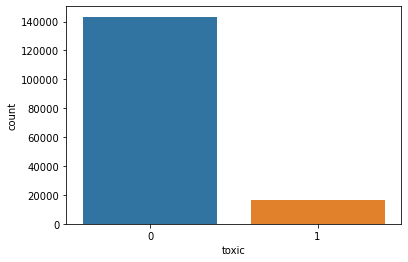

In [3]:
sns.countplot(x = 'toxic', data = data_raw)

**Итак, предварительный анализ датасета выполнен. Имеем 159000 комментариев, большинство из которых не токсичны. То есть на лицо несбалансированность датасета. Пропущенных значений и дубликатов нет, что радует. Целевая переменная принимает всего два значения, а значит, нам предстоит решить задачу бинарной классификации.** 

## EDA

(-0.5, 399.5, 199.5, -0.5)

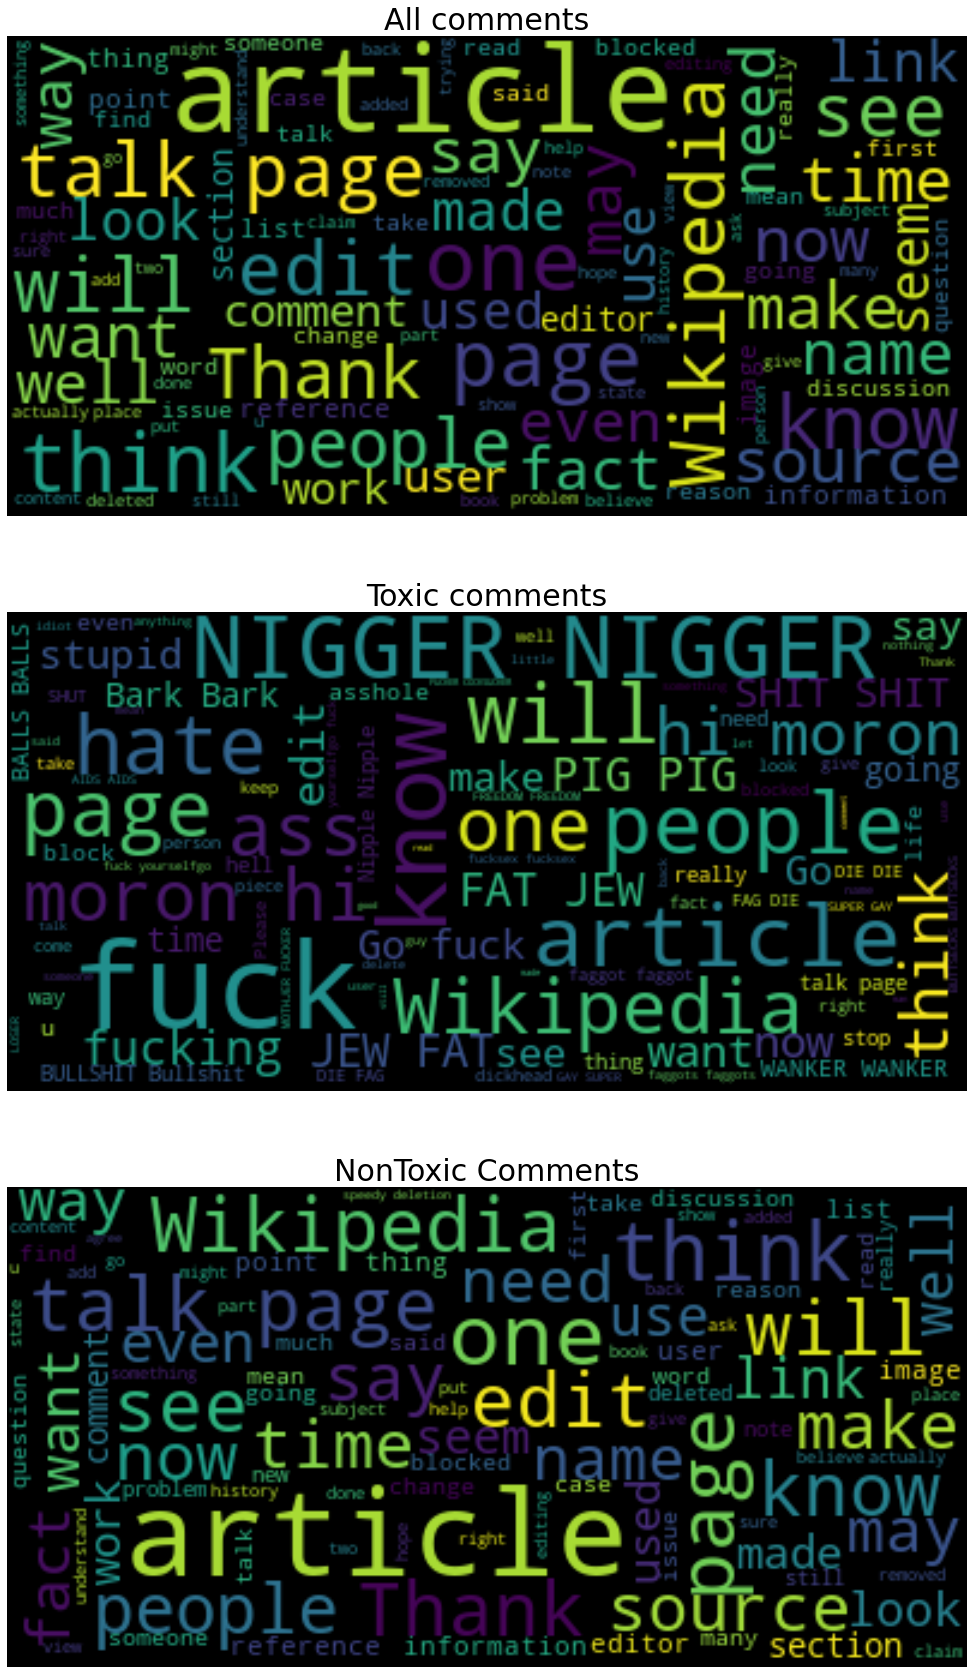

In [4]:
# Построим wordcloud для токсичных и нетоксичных комментариев

df_toxic = data_raw[data_raw['toxic']==1]
df_nottoxic = data_raw[data_raw['toxic']==0]

All = " ".join(review for review in data_raw.text)
toxic = " ".join(review for review in df_toxic.text)
nottoxic = " ".join(review for review in df_nottoxic.text)

fig, ax = plt.subplots(3, 1, figsize  = (30,30))
wordcloud_all = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(All)
wordcloud_toxic = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(toxic)
wordcloud_nottoxic = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(nottoxic)


ax[0].imshow(wordcloud_all, interpolation='bilinear')
ax[0].set_title('All comments', fontsize=30)
ax[0].axis('off')
ax[1].imshow(wordcloud_toxic, interpolation='bilinear')
ax[1].set_title('Toxic comments',fontsize=30)
ax[1].axis('off')
ax[2].imshow(wordcloud_nottoxic, interpolation='bilinear')
ax[2].set_title('NonToxic Comments',fontsize=30)
ax[2].axis('off')

**Ага, вот мы и посмотрели, что тут происходит. В основном оскорбления по расовому признаку и беспричинная ненависть. Однако стоит отметить, что некоторые слова попали сразу в два класса.**

In [5]:
# Добавим мета признаки

def add_meta_feat(df):
    
    # word_count
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

    # unique_word_count
    df['unique_word_count'] = df['text'].apply(lambda x: len(set(str(x).split())))
    
    return df

In [6]:
data = add_meta_feat(data_raw)

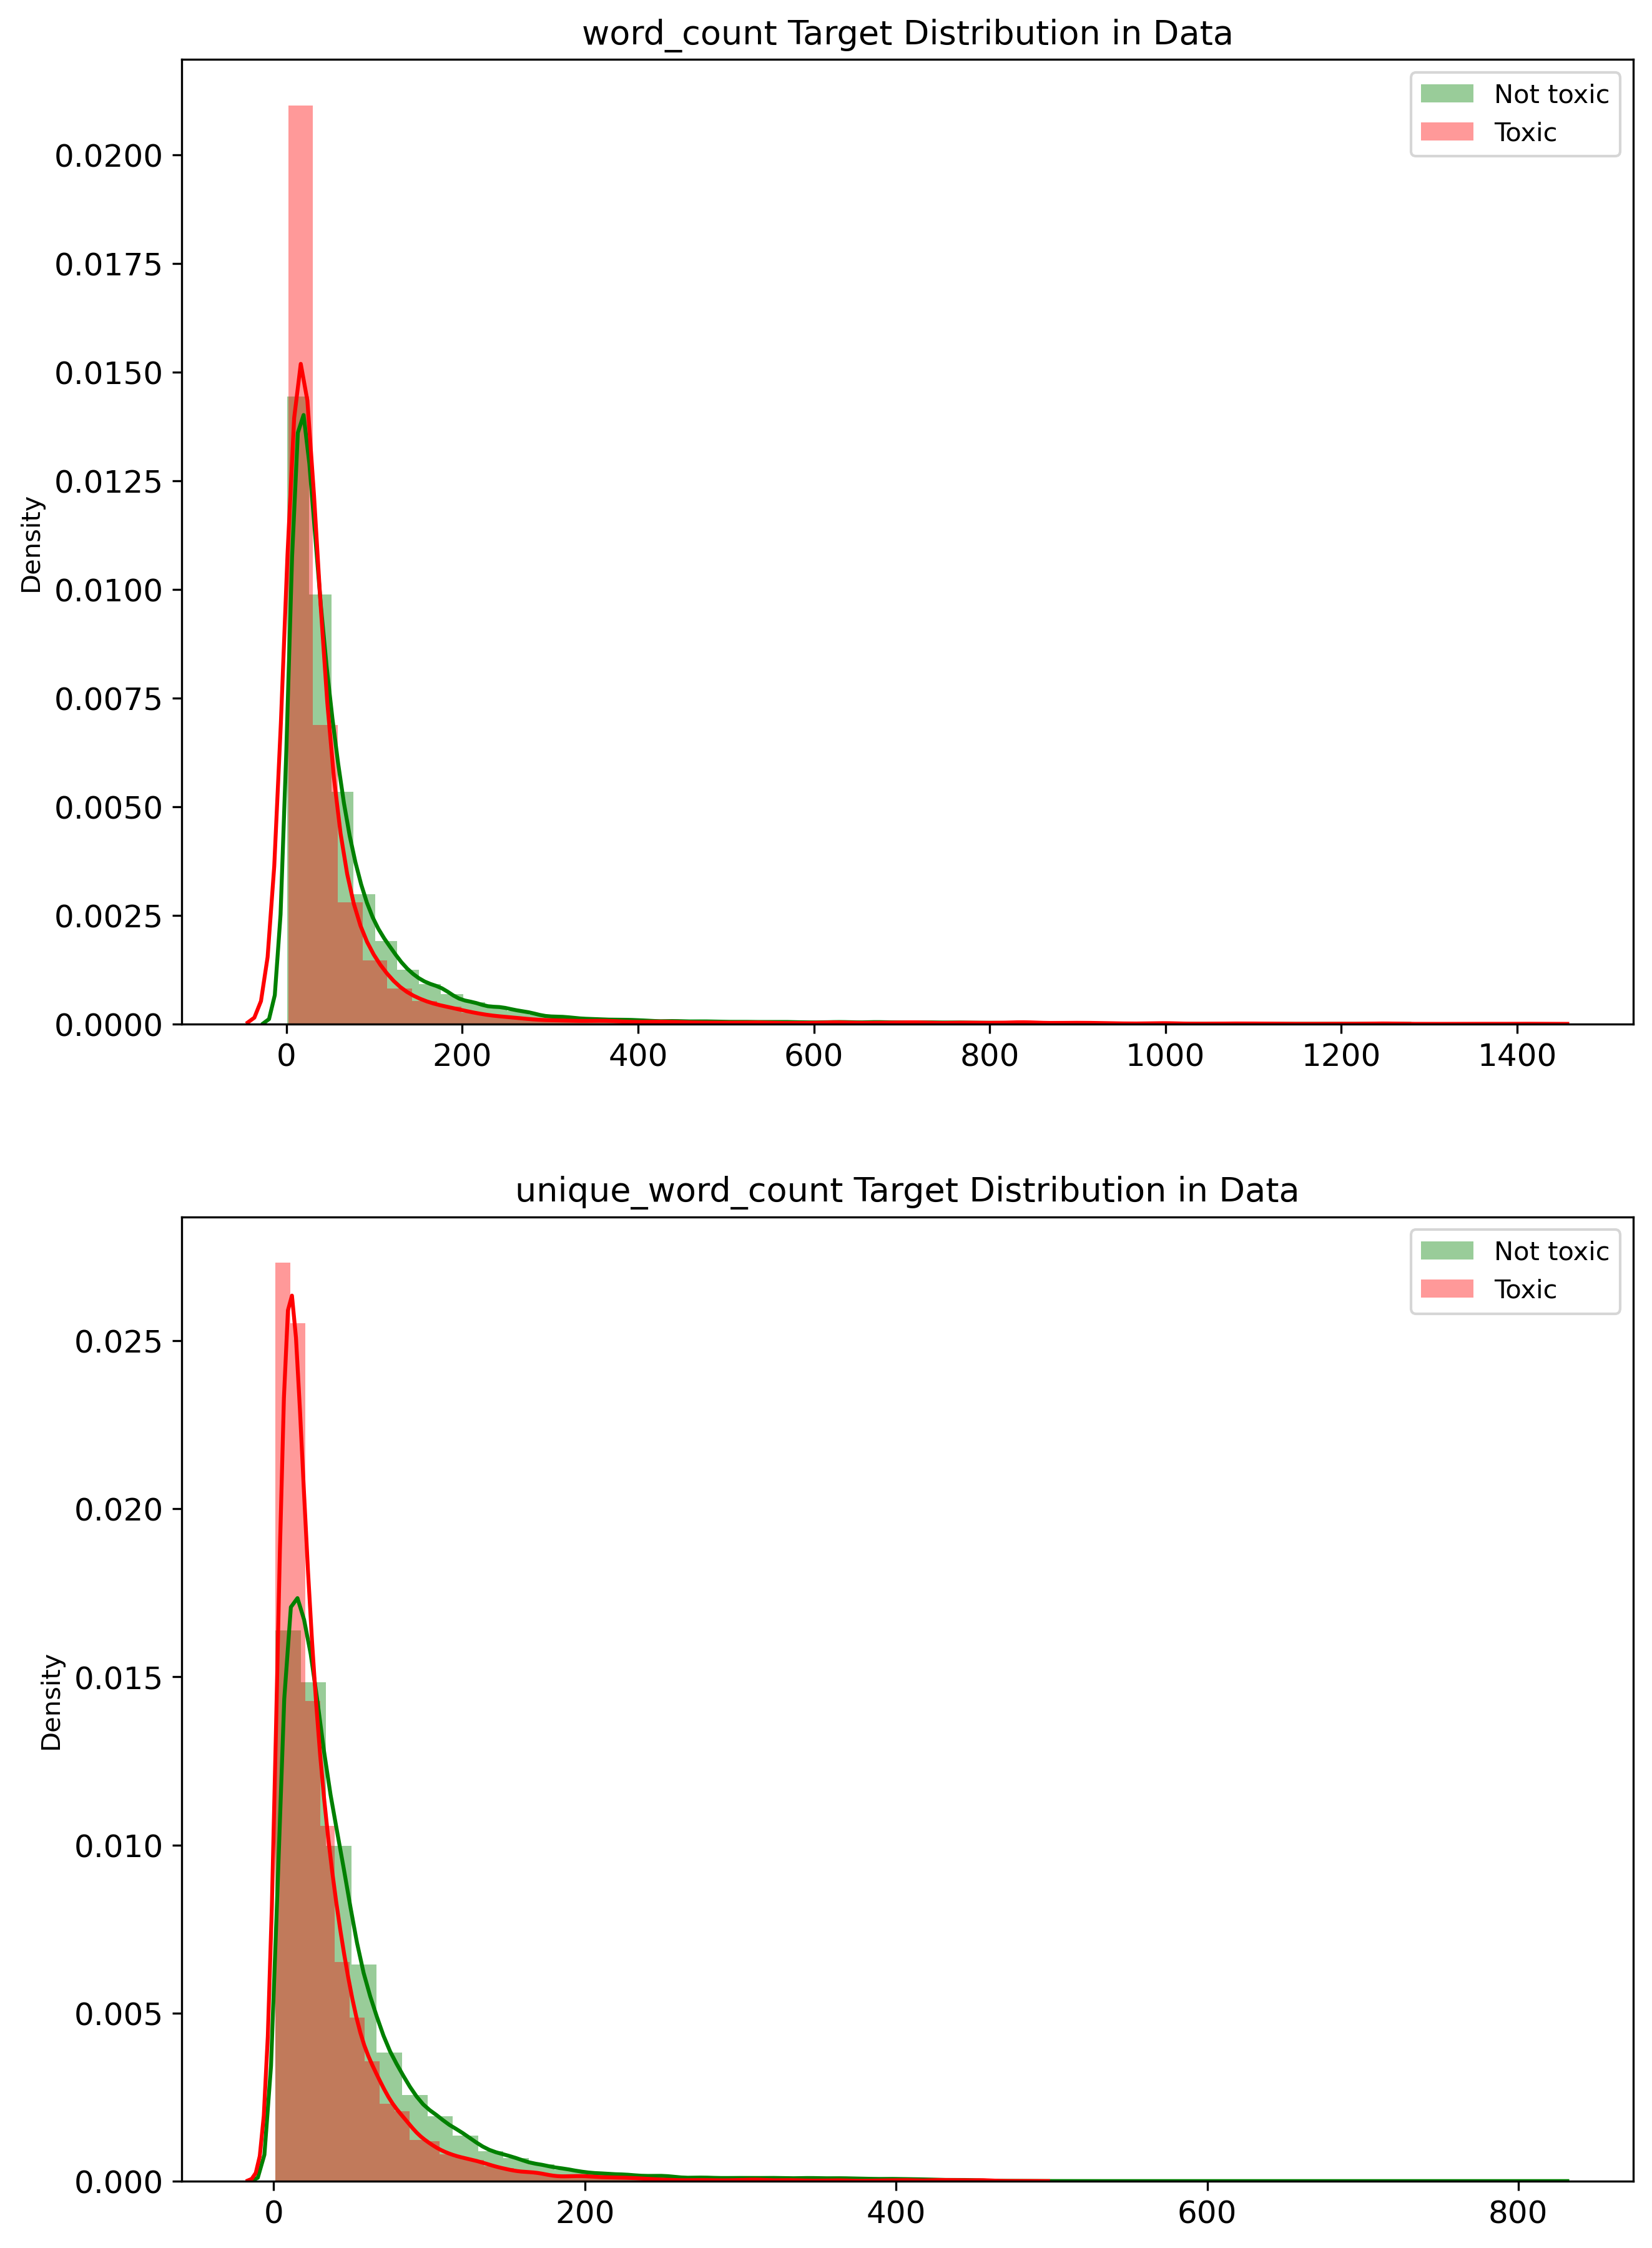

In [7]:
meta_features = ['word_count', 'unique_word_count']
TOXIC_COMMENTS = data['toxic'] == 1

fig, axes = plt.subplots(ncols=1, nrows=len(meta_features), figsize=(10, 15), dpi=300)

for i, feature in enumerate(meta_features):
    sns.distplot(data.loc[~TOXIC_COMMENTS][feature], label='Not toxic', ax=axes[i], color='green')
    sns.distplot(data.loc[TOXIC_COMMENTS][feature], label='Toxic', ax=axes[i], color='red')

    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].legend()

    axes[i].set_title(f'{feature} Target Distribution in Data', fontsize=13)

plt.show()

**Из графиков видно что токсичные комментарии чаще оказываются короче и при этом содержат больше уникальных слов.**

In [8]:
# Удалим пунктуацию

data = data_raw
if not sys.warnoptions:
    warnings.simplefilter("ignore")


def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

data['punct'] = data['text'].apply(lambda x: remove_punct(x))
data.head(3)

,text,toxic,word_count,unique_word_count,punct
0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0,43,41,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted They were...
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0,17,17,Daww He matches this background colour Im seemingly stuck with Thanks talk January UTC
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0,42,39,Hey man Im really not trying to edit war Its just that this guy is constantly removing relevant ...


In [9]:
# Токенизация

def tokenization(text):
    text = re.split('\W+', text)
    return text

data['tokenized'] = data['punct'].apply(lambda x: tokenization(x.lower()))
data.head(3)

,text,toxic,word_count,unique_word_count,punct,tokenized
0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0,43,41,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted They were...,"[explanation, why, the, edits, made, under, my, username, hardcore, metallica, fan, were, revert..."
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0,17,17,Daww He matches this background colour Im seemingly stuck with Thanks talk January UTC,"[daww, he, matches, this, background, colour, im, seemingly, stuck, with, thanks, talk, january,..."
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0,42,39,Hey man Im really not trying to edit war Its just that this guy is constantly removing relevant ...,"[hey, man, im, really, not, trying, to, edit, war, its, just, that, this, guy, is, constantly, r..."


In [10]:
# Избавимся от стоп-слов

stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
data['nonstop'] = data['tokenized'].apply(lambda x: remove_stopwords(x))
data.head(3)

,text,toxic,word_count,unique_word_count,punct,tokenized,nonstop
0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0,43,41,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted They were...,"[explanation, why, the, edits, made, under, my, username, hardcore, metallica, fan, were, revert...","[explanation, edits, made, username, hardcore, metallica, fan, reverted, werent, vandalisms, clo..."
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0,17,17,Daww He matches this background colour Im seemingly stuck with Thanks talk January UTC,"[daww, he, matches, this, background, colour, im, seemingly, stuck, with, thanks, talk, january,...","[daww, matches, background, colour, im, seemingly, stuck, thanks, talk, january, utc]"
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0,42,39,Hey man Im really not trying to edit war Its just that this guy is constantly removing relevant ...,"[hey, man, im, really, not, trying, to, edit, war, its, just, that, this, guy, is, constantly, r...","[hey, man, im, really, trying, edit, war, guy, constantly, removing, relevant, information, talk..."


In [11]:
# Лемматизация

wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

data['lemmatized'] = data['nonstop'].apply(lambda x: lemmatizer(x))
data.head(3)

,text,toxic,word_count,unique_word_count,punct,tokenized,nonstop,lemmatized
0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0,43,41,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted They were...,"[explanation, why, the, edits, made, under, my, username, hardcore, metallica, fan, were, revert...","[explanation, edits, made, username, hardcore, metallica, fan, reverted, werent, vandalisms, clo...","[explanation, edits, made, username, hardcore, metallica, fan, reverted, werent, vandalism, clos..."
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0,17,17,Daww He matches this background colour Im seemingly stuck with Thanks talk January UTC,"[daww, he, matches, this, background, colour, im, seemingly, stuck, with, thanks, talk, january,...","[daww, matches, background, colour, im, seemingly, stuck, thanks, talk, january, utc]","[daww, match, background, colour, im, seemingly, stuck, thanks, talk, january, utc]"
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0,42,39,Hey man Im really not trying to edit war Its just that this guy is constantly removing relevant ...,"[hey, man, im, really, not, trying, to, edit, war, its, just, that, this, guy, is, constantly, r...","[hey, man, im, really, trying, edit, war, guy, constantly, removing, relevant, information, talk...","[hey, man, im, really, trying, edit, war, guy, constantly, removing, relevant, information, talk..."


**Итак, мы провели исследовательский анализ. Создали несколько новых признаков, чтобы при обучении модели можно было понять, какой способ обработки наиболее подходящий для данной задачи.**

## Обучение

**Для обучения используем логистическую регрессию и LGB классификатор. Для подбора гиперпараметров используем Grid Search.**

In [12]:
# Разбиваем на обучающую и тестовую выборки

train, test = train_test_split(data, test_size=0.2, random_state=12345)

In [13]:
# Вызовем объект TF-IDF

count_tf_idf = TfidfVectorizer()

In [14]:
models = {
    'LogisticRegression': LogisticRegression(),
    'LGBMClassifier': lgb.LGBMClassifier()
}


params = {
    'LogisticRegression':{
          'class_weight':['balanced', None],
          'C':[.05,.1,.5,1,5,10,100]
    },        

    'LGBMClassifier': {
        'boosting_type':['gbdt'],
        'objective':['binary'],
        'learning_rate':[0.02,0.05],
        'num_iterations':[100, 500]
        }
}

In [15]:
# Функция для подбора гиперпараметров

def fit(train_features, train_actuals):
        for name in models.keys():
            est = models[name]
            est_params = params[name]
            gscv = GridSearchCV(estimator=est, param_grid=est_params, cv=5, n_jobs=-1, verbose=2, scoring='f1')
            gscv.fit(train_features, train_actuals)     
            predictions = gscv.predict(tfidf_test)
            result_list.append({
            'model': name,
            'feature': feature,
            'f1_score': f1_score(y_test, predictions),
            'best_params': gscv.best_estimator_
            })

In [16]:
# Выделим нужные признаки и обучим модели

result_list = []
features = ['lemmatized','tokenized']

for feature in features:
    X_train = train[feature]
    y_train = train['toxic']
    X_test = test[feature]
    y_test = test['toxic']

    train_corpus = X_train.astype('U')
    tfidf = count_tf_idf.fit_transform(train_corpus) 
    corpus_test = X_test.astype('U')
    tfidf_test = count_tf_idf.transform(corpus_test)

    fit(tfidf, y_train)    

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  3.3min finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 32.6min finished


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  4.3min finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 34.2min finished


In [17]:
# Записываем все результаты

results = pd.DataFrame(result_list, columns=['model','feature','f1_score','best_params'])

In [18]:
results.style.highlight_max(color = 'lightgreen', axis = 0)

,model,feature,f1_score,best_params
0,LogisticRegression,lemmatized,0.769541,"LogisticRegression(C=10, class_weight='balanced')"
1,LGBMClassifier,lemmatized,0.774014,"LGBMClassifier(learning_rate=0.05, num_iterations=500, objective='binary')"
2,LogisticRegression,tokenized,0.775798,"LogisticRegression(C=10, class_weight='balanced')"
3,LGBMClassifier,tokenized,0.770616,"LGBMClassifier(learning_rate=0.05, num_iterations=500, objective='binary')"


**Итак, лучший результат (0.78) дала логистическая регрессия на токенизированных данных.**

### BERT

Для решения нашей задачи надо использовать все доступные способы. Используем BERT - лучший вариант из доступных для обучения на эмбендингах. Поскольку для нее потребуется значительный вычислительный ресурс, то используем среду Google Colab. 

## Выводы

**Итак, мы провели классификацию отзывов для интернет-магазина. Значение метрики F1 составило 0.78. BERT в своем дефолтном варианте показал результат в 0.72. Задача выполнена.**